This notebook contains the code of the article: Understanding deep Convolutional Neural Networks with a practical use-case in Tensorflow and Keras as well as portions of the post's text. This will help understanding the code.

Link <a href="https://ahmedbesbes.com/understanding-deep-convolutional-neural-networks-with-a-practical-use-case-in-tensorflow-and-keras.html"> here </a>

This is what the convolution layer does: given a filter, it scans the input and generates a feature map.

> ** But what does this convolution operation really represent? How to interpret the resulting feature map? **

I started by stating that convolution layers capture visual patterns within an image. Let me illustrate this to convince you.

I'm going to load a cat image from the dataset. I'll then apply different convolutions on it, changing the kernel each time, and visualizing the results.

In [ ]:
%matplotlib inline
from scipy.signal import convolve2d
import numpy as np 
import cv2
from matplotlib import pyplot as plt

image = cv2.imread('./data/train/cats/cat.46.jpg')
# converting the image to grayscale
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

I'll define a function that takes a kenel as an input, performs a convolution on the image and then plots the original image and the convolved one next to it.

The kernel is a small square matrix (gray square in the figures above).

In [ ]:
def show_differences(kernel):
    convolved = convolve2d(image, kernel)
    fig = plt.figure(figsize=(15, 15))
    plt.subplot(121)
    plt.title('Original image')
    plt.axis('off')
    plt.imshow(image, cmap='gray')
    
    plt.subplot(122)
    plt.title('Convolved image')
    plt.axis('off')
    plt.imshow(convolved, cmap='gray')
    return convolved

Let's start by this filter:
$$ \frac{1}{9} \left[ 
\begin{array}{cccc}
1 & 1 & 1 \\
1 & 1 & 1 \\
1 & 1 & 1 \\ \end{array} \right]$$

It's called box blur. When this filter is applied to a pixel value in the input image,  it basically takes this pixel and its 8 neighbors (that's why we have 1 everywhere) and compute their average pixel value (that's why we devide by 9).

Mathematically, this is a simple average. Visually, it results in smoothing abrupt contrast transitions that appear in the image.

Box blur is highly used in **noise removal**.

Let's apply it on a cat image and see what it does.

In [ ]:
kernel = np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1]])/9
output = show_differences(kernel)

<img src="images/flou1.png">

If you closely look at the convolved image, you'll notice that it's smoother, with less white pixels (noise) sprinkled on it.

Now let's look at a more agressive bluring filter:
$$\frac{1}{64}\left[ 
\begin{array}{cccc}
1 & 1 & 1 & 1 & 1 & 1 & 1 & 1  \\
1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 \\
1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 \\
1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 \\
1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 \\
1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 \\
1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 \\
1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 \\ \end{array} \right]$$

In [ ]:
kernel = np.ones((8,8), np.float32)/64
dx = show_differences(kernel)

<img src="images/flou2.png">

Some filters are used to capture intrinsic image details like **edges**.

Here is one example that computes an approximation of the vertical changes in the image A.

$$G_x= A * \left[ 
\begin{array}{cccc}
-1 & 0 & 1\\
-2 & 0 & 2 \\
-1 & 0 & 1 \\ \end{array} \right]$$

In [ ]:
kernel = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
dx = show_differences(kernel)

<img src="images/dx.png">

The white areas are the ones that better respond to the filter, indicating the presence of a vertical edge. Look closely at the cat's left ear for example and notice how its edge is captured. 

Cool, right? Here is a second filter that does the same operation but for the horizontal changes.


$$G_y = A * \left[ 
\begin{array}{cccc}
1 & 2 & 1\\
0 & 0 & 0 \\
-1 & -2 & -1 \\ \end{array} \right]$$

In [ ]:
kernel = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
dy = show_differences(kernel)

<img src="images/dy.png">

Notice how the whiskers are detected.

The two previous filters are gradient operators. They allow, to some extent, to reveal an inherent structure in the image with respect to a direction. 

However, when G_x and G_y are combined in the following formula:

$$G = \sqrt{G_x^2 + G_y^2}$$

they allow an even better edge detection.

In [ ]:
mag = np.hypot(dx, dy)  # magnitude
mag *= 255.0 / np.max(mag)  # normalize (Q&D)

fig = plt.figure(figsize=(15, 15))
plt.subplot(121)
plt.title('Original image')
plt.axis('off')
plt.imshow(image, cmap='gray')

plt.subplot(122)
plt.title('Convoluted image with highlighted edges')
plt.axis('off')
plt.imshow(mag, cmap='gray')

<img src="images/edges.png">

## 4 - 1 Builiding a convnet from scratch

In this first section, we'll setup an end-to-end pipeline to train a CNN. We'll go through data preparation and augmentation, architecture design, training and validation. We'll plot the loss and accuracy metrics on both the train and validation set: this will allow us to assess the improvement of the model over the training.

### Data preparation

The first thing to do before starting is to download and unzip the <a href="https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/download/train.zip" style="text-decoration:none;">train</a> dataset from Kaggle.


In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
import os 
import cv2
from tqdm import tqdm_notebook
from random import shuffle
import shutil
import pandas as pd

We must now organize the data so that it's easily processed by keras.

We'll create a data folder in which we'll have in two subfolders:

+ train
+ validation

Each of them will have 2 folders: 

+ cats 
+ dogs

At the end we'll have the following structure:

<hr>
```javascript
data/
    train/
        dogs/
            dog001.jpg
            dog002.jpg
            ...
        cats/
            cat001.jpg
            cat002.jpg
            ...
    validation/
        dogs/
            dog001.jpg
            dog002.jpg
            ...
        cats/
            cat001.jpg
            cat002.jpg
```            
<hr>

This structrue will allow our model to know from which folder to fetch the images as well as their labels for either training or validation. 

Here's a function that allows you to construct this file tree. It has two parameters: the total number of images **n** and the ratio of validation set **r**.

In [2]:
def organize_datasets(path_to_data, n=4000, ratio=0.2):
    files = os.listdir(path_to_data)
    files = [os.path.join(path_to_data, f) for f in files]
    shuffle(files)
    files = files[:n]
    
    n = int(len(files) * ratio)
    val, train = files[:n], files[n:]
    

    shutil.rmtree('./data/')
    print('/data/ removed')

    for c in ['dogs', 'cats']: 
        os.makedirs('./data/train/{0}/'.format(c))
        os.makedirs('./data/validation/{0}/'.format(c))

    print('folders created !')

    for t in tqdm_notebook(train):
        if 'cat' in t:
            shutil.copy2(t, os.path.join('.', 'data', 'train', 'cats'))
        else:
            shutil.copy2(t, os.path.join('.', 'data', 'train', 'dogs'))
     
    for v in tqdm_notebook(val):
        if 'cat' in v:
            shutil.copy2(v, os.path.join('.', 'data', 'validation', 'cats'))
        else:
            shutil.copy2(v, os.path.join('.', 'data', 'validation', 'dogs'))
            
    print('Data copied!')

I used:

+ n : 25000 (the entire dataset)
+ r : 0.2

In [3]:
ratio = 0.2
n = 25000
organize_datasets(path_to_data='./train/', n=n, ratio=ratio)

Let's load Keras and its dependencies.

In [4]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras_tqdm import TQDMNotebookCallback
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras.callbacks import Callback

Using TensorFlow backend.


### Image generators and data augmentation

When training a model, we're not going to load the entire dataset in memory. This won't be efficient, especially if you use your local machine.

We're going to use the ImageDataGenerator class. It allows you to indefinitely stream the images by batches from the train and validation folders. Every batch flows through the network, makes a forward-prop, a back-prop then a parameter updates (along with the test on the validation data). Then comes the next batch and does the same thing, etc.

Inside the ImageDataGenerator object, we're going to introduce random modifications on each batch. It's a process we call **data augmentation**. It allows to generate more data so that our model would never see twice the exact same picture. This helps prevent overfitting and makes the model generalize better. 

We'll create two ImageDataGenerator objects.

**train_datagen** for the training set and **val_datagen** one for the validation set. The two of them will apply a rescaling on the image, but the train_datagen will introduce more modifications.

In [5]:
batch_size = 32

In [6]:
train_datagen = ImageDataGenerator(rescale=1/255.,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True
                                    )
val_datagen = ImageDataGenerator(rescale=1/255.)

From the two previous objects we're going to create two file generators:

+ train_generator
+ validation_generator

Each one generates, from its directory, batches of tensor image data with real-time data augmentation. The data will be looped over (in batches) indefinitely.

In [7]:
train_generator = train_datagen.flow_from_directory(
        './data/train/',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
        './data/validation/',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical')

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


### Model architecture

I'll use a CNN with three convolution/pooling layers and two fully connected layers.

The three conv layers will use respectively 32, 32 and 64 3x3 filters.

I used dropout on the two fully connected layers to prevent overfitting.

In [8]:
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

I used the stochastic gradient descent optimizer with learning rate of 0.01 and momentum of 0.9. 

I used the **binary crossentropy** loss function.

In [9]:
epochs = 50
lrate = 0.01
decay = lrate/epochs
sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

Keras provides a convenient method to display a summary of the model. For each layer, this shows up the output shape and the number of trainable parameters.

This a sanity check before starting fitting the model.

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 18, 18, 64)        0         
__________

Let's look at the network architecture:

### Visualizing the architecture

<img src="./images/model.png">

### Training the model

Before training the model, I defined two callback functions that will be called while training.

+ One for **early stopping** the training when the loss function stops improving on the validation data  
+ One for storing the validation loss and accuracy of each epoch: this allows to plot the training error


In [11]:
## Callback for loss logging per epoch
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        
history = LossHistory()

## Callback for early stopping the training
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=2,
                              verbose=0, mode='auto')

I also used <a  href="https://github.com/bstriner/keras-tqdm"> keras-tqdm</a> which is an **awesome progress-bar ** that perfectly integrates with Keras. 

It allows you to monitor the training of you models very easily.

What you need to do is simply load the TQDMNotebookCallback class from keras_tqdm then pass it as a third callback functions.

```python
from keras_tqdm import TQDMNotebookCallback
```

Here's what keras-tqdm looks like on simple example:

<img src="./images/keras-tqdm.png"></img>

A few words about the training:

- We'll use the fit_generator method which is a variant (of the standard fit method) that takes a generator as input.

- We'll train the model over 50 epochs: over one epoch 20000 unique and augmented images will flow by batch of 32 to the network, performing a forward and back propagation and adjusting the weights with SGD. The idea of using multiple epochs is to prevent overfitting.


<hr>
```python
fitted_model = model.fit_generator(
        train_generator,
        steps_per_epoch= int(n * (1-ratio)) // batch_size,
        epochs=50,
        validation_data=validation_generator,
        validation_steps= int(n * ratio) // batch_size,
        callbacks=[TQDMNotebookCallback(leave_inner=True, leave_outer=True), early_stopping, history],
        verbose=0)
```
<hr>

This is a **heavy computation**: 

- If you're on your laptop this may take about 15 minutes per epoch
- If you're using an the p2.xlarge EC2 instance like me, this takes about 2 minutes or so per epoch

tqdm allows you to monitor the validation loss and accuracy on each epochs. This is useful to check the quality of your model.

### Classification results

We reached **89.4% accuracy** (on the validation data) in 34 epochs (training/validation error and accuracy displayed below) 

This is a good result given that I didn't invest too much time designing the architecture of the network.

Now let's save the model for later use.

<hr>
```python
model.save('./models/model4.h5')
```
<hr>

Let's plot the train and validation losses on the same graph:

<hr>
```python
losses, val_losses = history.losses, history.val_losses
fig = plt.figure(figsize=(15, 5))
plt.plot(fitted_model.history['loss'], 'g', label="train losses")
plt.plot(fitted_model.history['val_loss'], 'r', label="val losses")
plt.grid(True)
plt.title('Training loss vs. Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
```
<hr>

<img src="./images/loss.png"></img>

We interrupt the training when the validation loss doesn't improve on two successive epochs.

Let's now plot the accuracy on both the training set and validation set.

<hr>
```python
losses, val_losses = history.losses, history.val_losses
fig = plt.figure(figsize=(15, 5))
plt.plot(fitted_model.history['acc'], 'g', label="accuracy on train set")
plt.plot(fitted_model.history['val_acc'], 'r', label="accuracy on validation set")
plt.grid(True)
plt.title('Training Accuracy vs. Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
```
<hr>

<img src="./images/accuracy.png"></img>

These two metrics keep increasing before reaching a plateau where the model eventually starts overfitting (from epoch 34).

## 4 - 2 Loading a pre-trained model 

So far so good: we designed a custom convnet that performs reasonably well on the valiation data with ~ 89% accuracy.
 
There is however a way to get a better score: loading the weights of a pre-trained convnet on a large dataset that includes images of cats and dogs among 1000 classes. Such a network would have learnt relevant features that are relevant to our classification.

I'll load the weights of the VGG16 network: more specifically, I'm going to load the network weights up to the last conv layer. This network part acts as a feature detector to which we're going to add fully connected layers for our classification task.
 
VGG16 is a very large network in comparison to LeNet5. It has 16 layers with trainable weights and around 140 millions parameters. To learn more about VGG16 please refer to this <a href="https://arxiv.org/pdf/1409.1556.pdf" style="text-decoration:none;"> pdf link.</a>

We first start by loading the VGG16 weights (trained on ImageNet) by specifying that we're not interested in the last three FC layers.

In [12]:
from keras import applications
# include_top: whether to include the 3 fully-connected layers at the top of the network.
model = applications.VGG16(include_top=False, weights='imagenet')
datagen = ImageDataGenerator(rescale=1. / 255)

Now we pass the images through the network to get a feature representation that we'll input to a neural network classifier.

We do this for the training set and the validation set.

In [13]:
generator = datagen.flow_from_directory('./data/train/',
                                        target_size=(150, 150),
                                        batch_size=batch_size,
                                        class_mode=None,
                                        shuffle=False)

bottleneck_features_train = model.predict_generator(generator, int(n * (1 - ratio)) // batch_size)
np.save(open('./features/bottleneck_features_train.npy', 'wb'), bottleneck_features_train)

Found 20000 images belonging to 2 classes.


In [14]:
generator = datagen.flow_from_directory('./data/validation/',
                                        target_size=(150, 150),
                                        batch_size=batch_size,
                                        class_mode=None,
                                        shuffle=False)

bottleneck_features_validation = model.predict_generator(generator, int(n * ratio) // batch_size,)
np.save('./features/bottleneck_features_validation.npy', bottleneck_features_validation)

Found 5000 images belonging to 2 classes.


When the images are passed to the network, they are in the right orders. So we associate the labels to them easily.

In [15]:
train_data = np.load('./features/bottleneck_features_train.npy')
train_labels = np.array([0] * (int((1-ratio) * n) // 2) + [1] * (int((1 - ratio) * n) // 2))

validation_data = np.load('./features/bottleneck_features_validation.npy')
validation_labels = np.array([0] * (int(ratio * n) // 2) + [1] * (int(ratio * n) // 2))

Now we design a small fully connected network that plugs in to the features extracted from the VGG16 and acts as the classification part of a CNN.

In [16]:
model = Sequential()
model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy', metrics=['accuracy'])

In [17]:
fitted_model = model.fit(train_data, train_labels,
          epochs=15,
          batch_size=batch_size,
          validation_data=(validation_data, validation_labels[:validation_data.shape[0]]),
          verbose=0,
          callbacks=[TQDMNotebookCallback(leave_inner=True, leave_outer=False), history])

We reached **90.7% accuracy** on 15 epochs only. Quite not bad.

Note that each epoch takes around 1 minute on my personal laptop.

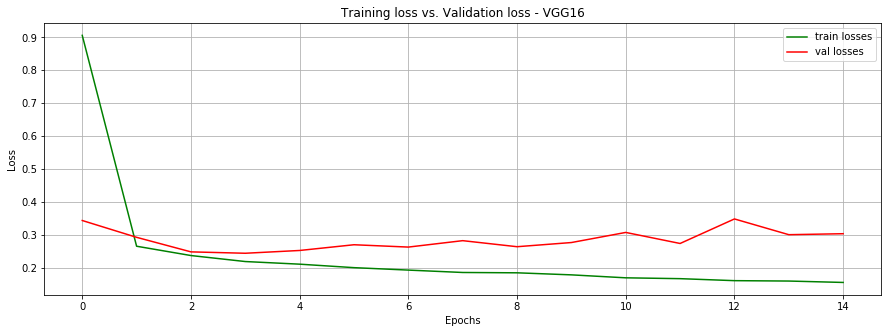

In [18]:
fig = plt.figure(figsize=(15, 5))
plt.plot(fitted_model.history['loss'], 'g', label="train losses")
plt.plot(fitted_model.history['val_loss'], 'r', label="val losses")
plt.grid(True)
plt.title('Training loss vs. Validation loss - VGG16')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

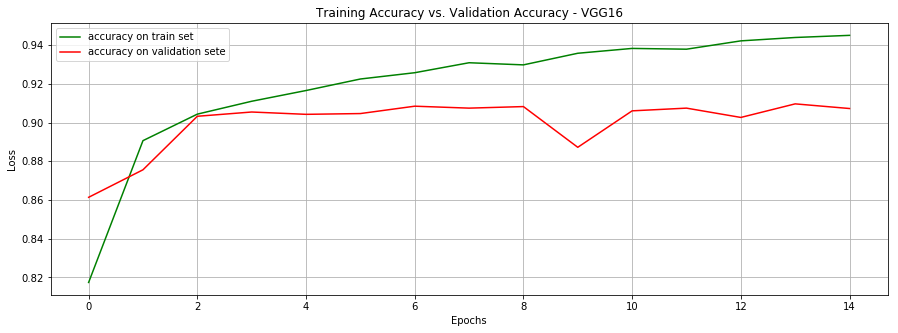

In [19]:
fig = plt.figure(figsize=(15, 5))
plt.plot(fitted_model.history['acc'], 'g', label="accuracy on train set")
plt.plot(fitted_model.history['val_acc'], 'r', label="accuracy on validation sete")
plt.grid(True)
plt.title('Training Accuracy vs. Validation Accuracy - VGG16')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

Many deep learning pioneers encourage to use pre-trained networks for classification tasks. In fact, this usually leverages the training of a very large network on a very large dataset. So the motto is 

> Don't be a hero. Don't reinvent the wheel.

# Conclusion

This article was an opportunity to go through the theory behind convolutional neural networks and explain each of their principal components in more details.

This was also a hands-on guide to setup a deep learning dedicated environment on AWS and develop an end-to-end model from scratch as well as an enhanced model based on a pre-trained one. 

Using python for deep learning is extermely fun. Keras made it easier for preprocessing the data and building up the layers. 
Keep in mind that if you want someday to build custom neural net components, you'll have to switch to another framework. 

I hope this gave you a practical intuition about the convnets mechanisms and a strong appetite to learn more.

Convnets are amazingly powerful. Anyone working on computer vision believes in their robustness and efficiency.

Their applications are getting a larger scope. NLP practictioners are now the ones who are switching to convnets. Here are some of their applications:

- Text classification using CNNs : <a href="https://chara.cs.illinois.edu/sites/sp16-cs591txt/files/0226-presentation.pdf"> link </a>
- Automated image captioning (Image + Text): <a href="https://cs.stanford.edu/people/karpathy/sfmltalk.pdf">link </a>
- Text classification at **character level**: <a href="https://papers.nips.cc/paper/5782-character-level-convolutional-networks-for-text-classification.pdf"> link </a>

# References

Here's a list of some references I used to learn about neural nets and convnets:

1. <a href="http://neuralnetworksanddeeplearning.com" style="text-decoration:none;"> neuralnetworksanddeeplearning.com </a>: By far the best notes notes neural networks and deep learning. Recommend this to anyone who want to start learning about neural nets.

2. <a style="text-decoration:none;" href="http://cs231n.github.io/convolutional-networks/"> CS231n Convolutional Neural Networks for Visual Recognition </a>: Andrej Karpathy's lectures at Stanford. Great mathematical focus.

3. A Beginner Guide to Understanding Neural Networks: A three-part post explaining CNNs, from the basic high level inuition to the architecture details. Very interesting read. Learnt a lot from it.
    + <a style="text-decoration:none;" href="https://adeshpande3.github.io/adeshpande3.github.io/A-Beginner's-Guide-To-Understanding-Convolutional-Neural-Networks/"> part 1 </a>
    + <a style="text-decoration:none;" href="https://adeshpande3.github.io/adeshpande3.github.io/A-Beginner's-Guide-To-Understanding-Convolutional-Neural-Networks-Part-2/"> part 2 </a>
    + <a style="text-decoration:none;" href="https://adeshpande3.github.io/adeshpande3.github.io/The-9-Deep-Learning-Papers-You-Need-To-Know-About.html"> part 3 </a>

4. <a style="text-decoration:none;" href="https://blog.keras.io/running-jupyter-notebooks-on-gpu-on-aws-a-starter-guide.html"> Running jupyter notebooks on GPU on AWS <a>

5. <a style="text-decoration:none;" href="https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html"> Building powerful image classification models using very little data </a>

6. <a style="text-decoration:none;" href="https://www.kaggle.com/jeffd23/catdognet-keras-convnet-starter"> CatdogNet - Keras Convnet Starter </a>

7. <a style="text-decoration:none;" href="https://ujjwalkarn.me/2016/08/09/quick-intro-neural-networks/"> A quick introduction to Neural Networks </a>

8. <a style="text-decoration:none;" href="https://ujjwalkarn.me/2016/08/11/intuitive-explanation-convnets/"> An Intuitive Explanation of Convolutional Neural Networks</a>

9. <a style="text-decoration:none;" href="https://hackernoon.com/visualizing-parts-of-convolutional-neural-networks-using-keras-and-cats-5cc01b214e59"> Visualizing parts of Convolutional Neural Networks using Keras and Cats </a>
